# Image Processing using Convolutional Neural Networks

- Created an image classifier using PyTorch, building and training a CNN model to classify images accurately
- Developed a denoising model using PyTorch, leveraging a CNN to remove noise from images and enhance visual quality.


In [ ]:
# Importing necessary libraries

import torch  # Core PyTorch library for tensor operations
from torchvision import datasets, transforms  # Datasets and transformations for computer vision
import torch.nn as nn  # Neural network components
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
from torch.utils.data import DataLoader, Dataset, random_split, Subset  # Data handling utilities

# SVHN Dataset

Used the **Street View House Numbers (SVHN) dataset** to develop a denoising algorithm and a classification task. The SVHN dataset consists of over **600,000** color images of house numbers collected from Google Street View images. Each image is a 32x32 pixel RGB image capturing digits (0-9) in real-world scenarios. The dataset can be found at [this link](http://ufldl.stanford.edu/housenumbers/).

- **Training set**: 73,257 images
- **Testing set**: 26,032 images

In [ ]:
# Define transformations for the dataset
transform = transforms.ToTensor()

# Load the training and test datasets
trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Set batch size as a parameter
batch_size = 64

# Function to create data loaders with a specified batch size
def get_dataloader(dataset, batch_size, shuffle):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create data loaders for training and testing
trainloader = get_dataloader(trainset, batch_size=batch_size, shuffle=True)
testloader = get_dataloader(testset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


# Visualization of SVHN dataset

In [ ]:
# Define the class labels for the SVHN dataset
classes = [str(i) for i in range(10)]

# Function to display a grid of images with specified rows, columns, and class labels
def show_images_grid(dataloader, rows, cols):
    # Get a batch of training images and labels
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < len(images):
                npimg = images[idx].numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].set_title(f'Class: {classes[labels[idx]]}')
                axes[i, j].axis('off')
                idx += 1
    plt.tight_layout()
    plt.show()

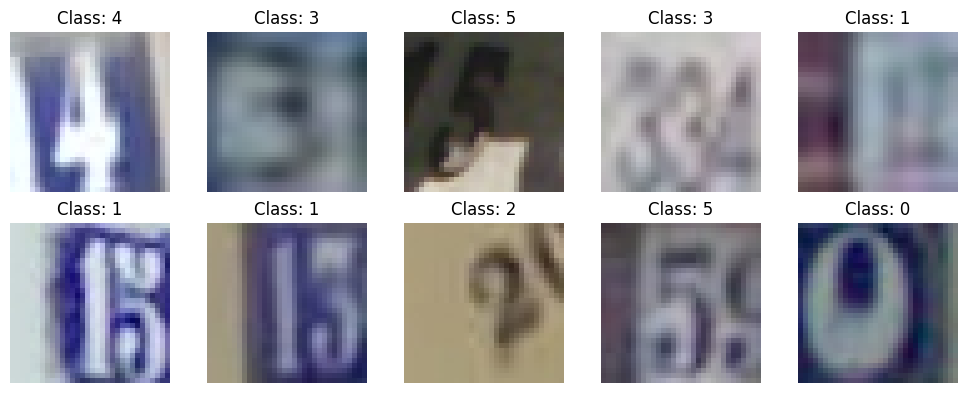

In [ ]:
# Display a 2x5 grid of images from trainloader
show_images_grid(trainloader, rows=2, cols=5)

The `del` keyword deletes variables from memory, freeing up space. This is useful in large projects, especially deep learning, where datasets and data loaders use significant memory. Removing these variables ensures available memory for later code and helps avoid conflicts with similar names.


In [ ]:
del trainset, testset, trainloader, testloader, transform, batch_size, get_dataloader

# SVHN Image Classification Using a Convolutional Neural Network (CNN) 

Implementation of a CNN model and used it to classify images from the SVHN dataset. Built an accurate model that can recognize and classify house number digits in real-world images.


In [ ]:
# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Hyper-Parameters:

In [ ]:
batch_size = 64           # Batch size for data loading
learning_rate = 0.05      # Learning rate for optimizer
num_epochs = 20           # Number of training epochs

Loading the dataset

In [ ]:
# Define transformations for SVHN dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

# Load training and test datasets with transformations
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Create data loaders with specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


## CNN Model

1. **Convolutional Layers**:
   - Three convolutional layers with:
     - `kernel_size=3`, `stride=1`, `padding=1`
     - Output channels:
       - First layer: 32 channels
       - Second layer: 64 channels
       - Third layer: 128 channels
   - Each convolutional layer is followed by:
     - Batch normalization to stabilize and speed up training
     - ReLU activation for non-linearity
     - Max pooling (`kernel_size=2`, `stride=2`) to reduce spatial dimensions

2. **Fully Connected Layers**:
   - Flatten the output from the convolutional layers.
   - First fully connected layer with 128 units and ReLU activation.
   - Final fully connected layer with 10 units for classification (one for each class in SVHN).

In [ ]:
import torch
import torch.nn as nn

class SVHNClassifier(nn.Module):
    def __init__(self):
        super(SVHNClassifier, self).__init__()

        # Convolutional layers
        self.cl1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cl2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cl3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.cl1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.cl2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.cl3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)

        return x


## Train the network
Train the SVHN_CNN model to classify SVHN dataset.



In [ ]:
# Initialize model and move to device
model = SVHNClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy includes softmax
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss_batches = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            loss_batches.append(loss.item())

    accuracy = 100 * correct / total
    avg_loss = np.mean(loss_batches)
    return accuracy, avg_loss


In [ ]:
# Training the model

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on train and test sets after each epoch

    train_accuracy, train_loss = evaluate(model, train_loader, criterion)
    test_accuracy, test_loss = evaluate(model, test_loader, criterion)


    print(f'Epoch {epoch+1:02d}/{num_epochs:02d} - Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')
    print(f'            - Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')
    print("-" * 60)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(f'Final Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
print(f'Final Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n')

Epoch 01/20 - Train Loss: 0.424950, Train Acc: 86.77%
            - Test Loss: 0.489822, Test Acc: 84.95%
------------------------------------------------------------
Epoch 02/20 - Train Loss: 0.326006, Train Acc: 90.04%
            - Test Loss: 0.403777, Test Acc: 87.91%
------------------------------------------------------------
Epoch 03/20 - Train Loss: 0.321805, Train Acc: 89.69%
            - Test Loss: 0.389070, Test Acc: 88.19%
------------------------------------------------------------
Epoch 04/20 - Train Loss: 0.240186, Train Acc: 92.74%
            - Test Loss: 0.355114, Test Acc: 89.13%
------------------------------------------------------------
Epoch 05/20 - Train Loss: 0.178326, Train Acc: 94.85%
            - Test Loss: 0.294293, Test Acc: 91.66%
------------------------------------------------------------
Epoch 06/20 - Train Loss: 0.161171, Train Acc: 95.28%
            - Test Loss: 0.310466, Test Acc: 91.43%
-----------------------------------------------------------

In [ ]:
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

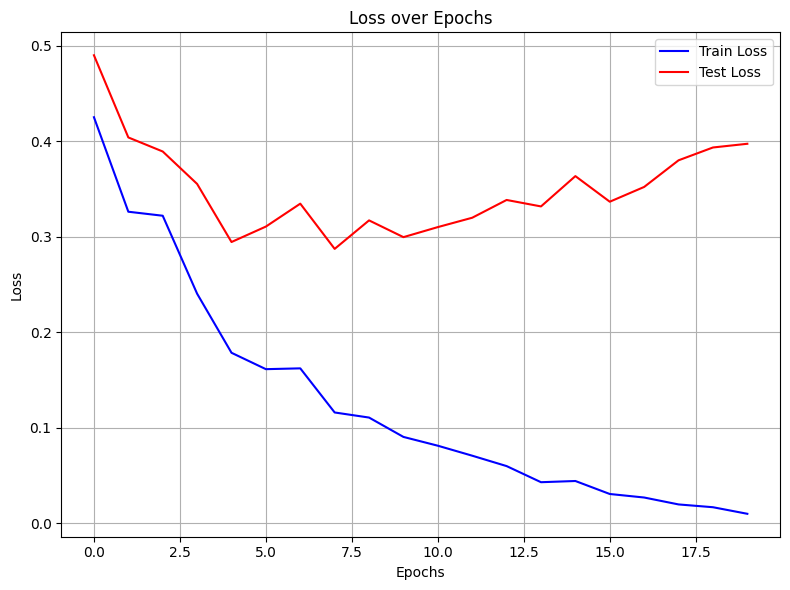

In [ ]:
# Plot loss
plot_metrics(train_losses, test_losses, 'Loss')

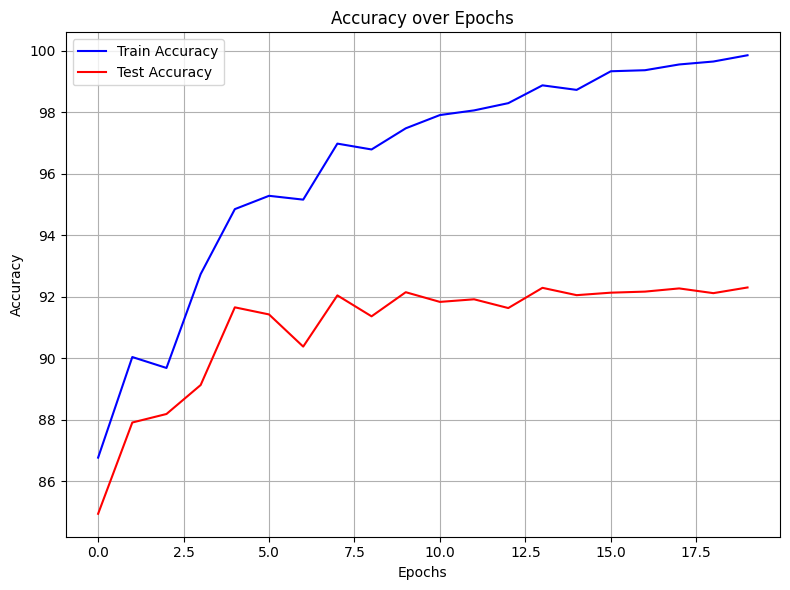

In [ ]:
# Plot accuracy
plot_metrics(train_accuracies, test_accuracies, 'Accuracy')

# SVHN Denoising with Convolution Neural Network (CNN)
Convolutional Neural Network (CNN) have also been quite successful in the field of image processing. Train a network that, given a noisy image, recovers the original image. 






Again, we remove these variables ensures available memory for later code and helps avoid conflicts with similar names.

In [ ]:
del device, batch_size, learning_rate, num_epochs,\
     train_dataset, test_dataset, train_loader, test_loader, transform,\
     SVHNClassifier, model, criterion, optimizer, evaluate,\
     train_losses, test_losses, train_accuracies, test_accuracies, show_images_grid, classes

In [ ]:
# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Create the Noisy dataset

### Defining a Custom Noise Transformation
Define a custom transformation that applies noise to each image by randomly dropping pixels. This transformation will be used to generate a noisy version of every image in the dataset.

In [ ]:
# Custom transformation to add noise by dropping pixels with a given probability for each channel independently
class AddNoiseTransform:
    def __init__(self, drop_prob=0.1):
        self.drop_prob = drop_prob

    def __call__(self, img):
        channel_mask = (torch.rand(img.shape) > self.drop_prob).float()
        noisy_img = img * channel_mask
        return noisy_img

### Creating a Dataset of Paired Images: Original and Noisy
We define a dataset that pairs each original image with a corresponding noisy image. This dataset is structured so that each data sample includes both the clean image (as the label) and the noisified version (as the feature). We then create PyTorch dataloaders where each element contains a pair of original and noisy images.

In [ ]:
# PairDataset class that returns a pair of images: (original, noisy)
class PairDataset(Dataset):
    def __init__(self, dataset_origin, dataset_noisy):
        assert len(dataset_origin) == len(dataset_noisy), "Datasets must be of the same length"
        self.dataset_origin = dataset_origin
        self.dataset_noisy = dataset_noisy

    def __getitem__(self, index):
        clean_img, _ = self.dataset_origin[index]
        noisy_img, _ = self.dataset_noisy[index]
        return clean_img, noisy_img

    def __len__(self):
        return len(self.dataset_origin)

In [ ]:
# Function to create paired dataset for specific classes
def create_paired_dataloader(classes, num_samples=1500, batch_size=64, drop_prob=0.5, split='train'):
    """
    Creates a DataLoader for a paired dataset with noisy and clean images from specified classes.

    Parameters:
    - classes (list): List of class labels to include (e.g., [0, 1, 2, 3, 4] or [5, 6, 7, 8, 9]).
    - num_samples (int): Number of samples to use from the filtered classes.
    - batch_size (int): Batch size for the DataLoader.
    - drop_prob (float): Drop probability for AddNoiseTransform.
    - split (str): Dataset split to load ('train' or 'test').

    Returns:
    - DataLoader: A DataLoader for the paired dataset.
    """

    # Define transformations
    transform_clean = transforms.ToTensor()
    transform_noisy = transforms.Compose([
        transforms.ToTensor(),
        AddNoiseTransform(drop_prob=drop_prob)
    ])

    # Load the specified dataset split
    dataset_clean_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_clean)
    dataset_noisy_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_noisy)

    # Filter to include only samples with specified classes
    indices = [i for i, (_, label) in enumerate(dataset_clean_full) if label in classes]

    # Take only the first `num_samples` samples after filtering
    subset_indices = indices[:num_samples]

    # Create clean and noisy subsets
    dataset_clean = Subset(dataset_clean_full, subset_indices)
    dataset_noisy = Subset(dataset_noisy_full, subset_indices)

    # Create the paired dataset
    paired_dataset = PairDataset(dataset_clean, dataset_noisy)

    # DataLoader for paired dataset
    paired_dataloader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)

    return paired_dataloader

## Implementing a CNN for Image Denoising**

Implement a Convolutional Neural Network (CNN) to map noisy images to their original, clean versions. This architecture consists of two convolutional layers.

### **Architecture Details**

1. **First Convolutional Layer**
   - **Setup**: `kernel_size=3`, `padding=1`, `stride=1` to maintain image dimensions.
   - **Input**: 32x32x3 images.
   - **Output**: Feature maps of size 32x32x30.
   - **Activation**: Apply ReLU for non-linearity.

2. **Second Convolutional Layer**
   - **Setup**: Same kernel size, padding, and stride as above.
   - **Output**: 32x32x3 to match the original image dimensions.
   - **Activation**: Sigmoid to constrain values between 0 and 1.

3. **Hyperparameters**
   - `input_channels=3`, `output_channels=3`, `feature_maps=30`.


In [ ]:
class ImageDenoisingCNN(nn.Module):
    def __init__(self):
        super(ImageDenoisingCNN, self).__init__()
        self.cl1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1, stride=1)
        self.cl2 = nn.Conv2d(in_channels=30, out_channels=3, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        x = self.cl1(x)
        x = self.relu(x)
        x = self.cl2(x)
        x = self.sigmoid(x)

        return x


To understand the model’s complexity, we can calculate the total number of trainable parameters in ImageDenoisingCNN. Each parameter contributes to the model's ability to learn patterns in the data.

In [ ]:
model = ImageDenoisingCNN()

# Calculate and print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of trainable parameters in ImageDenoisingCNN:', num_params)

Total number of trainable parameters in ImageDenoisingCNN: 1653


## Denoising SVHN Images
Building and evaluating a model that can remove noise from SVHN images in the first 5 classes (0 through 4). The model is trained and tested on a dataset of noisy images paired with their clean counterparts, using only 1,500 samples per class.


In [ ]:
# Display a single row of images with specified columns
def show_images_grid2(images, title, cols):
    fig, axes = plt.subplots(1, cols, figsize=(cols * 2, 2))
    if cols == 1:
        axes = [axes]

    for idx in range(cols):
        if idx < len(images):
            img = images[idx].numpy().transpose((1, 2, 0))
            axes[idx].imshow(img)
            axes[idx].set_title(title)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer, device='cuda'):
    """
    Train the model on the training dataset and evaluate it on the test dataset.

    Parameters:
    - train_loader: DataLoader for the training set
    - test_loader: DataLoader for the test set
    - model: Neural network model to train
    - epochs: Number of training epochs
    - loss_function: Loss function for training
    - optimizer: Optimizer for updating model weights
    - device: Device to use for training ('cuda' or 'cpu')

    Returns:
    - train_loss_epochs: List of average training losses per epoch
    - test_loss_epochs: List of average test losses per epoch
    """

    model.to(device)

    train_loss_epochs = []
    test_loss_epochs = []

    for epoch in range(epochs):
        model.train()
        train_loss_batches = []

        for batch_idx, (clean_images, noisy_images) in enumerate(train_loader):
            clean_images, noisy_images = clean_images.to(device), noisy_images.to(device)
            optimizer.zero_grad()
            denoised_images = model(noisy_images)
            loss = loss_function(denoised_images, clean_images)
            loss.backward()
            optimizer.step()

            train_loss_batches.append(loss.item())

            if epoch % 5 == 0 and batch_idx == len(train_loader) - 1:
                show_images_grid2(clean_images[:5].detach().cpu(), title="Clean", cols=5)
                show_images_grid2(noisy_images[:5].detach().cpu(), title="Noisy", cols=5)
                show_images_grid2(denoised_images[:5].detach().cpu(), title="Denoised", cols=5)

        train_loss_epoch = np.mean(train_loss_batches)
        train_loss_epochs.append(train_loss_epoch)

        test_loss = evaluate(test_loader, model, loss_function, device)

        print(f'Epoch {epoch+1:02d}/{epochs:02d} - Train Loss: {train_loss_epoch:.6f}, Test Loss: {test_loss:.6f}')

        test_loss_epochs.append(test_loss)

    return train_loss_epochs, test_loss_epochs


In [ ]:
def evaluate(dataloader, model, loss_function, device='cuda'):
    """
    Evaluate the model on the test dataset and return the average loss.
    """

    model.eval()
    test_losses = []

    with torch.no_grad():

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_losses.append(loss.item())


    avg_loss = np.mean(test_losses)
    return avg_loss


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


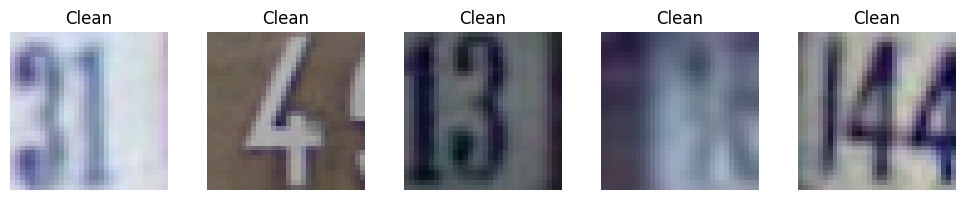

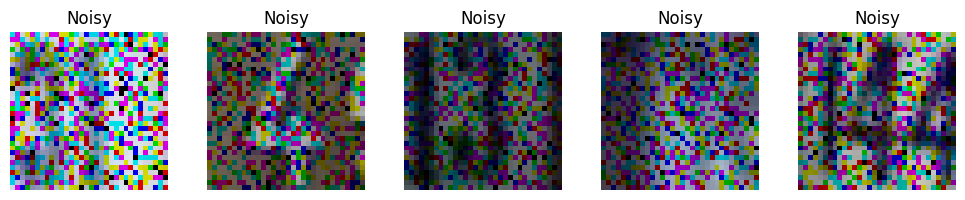

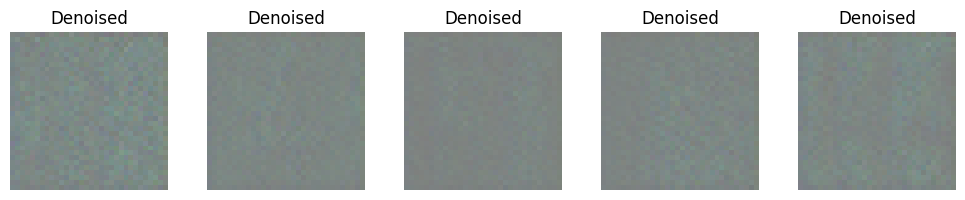

Epoch 01/100 - Train Loss: 0.042718, Test Loss: 0.115748
Epoch 02/100 - Train Loss: 0.041798, Test Loss: 0.114408
Epoch 03/100 - Train Loss: 0.041349, Test Loss: 0.113637
Epoch 04/100 - Train Loss: 0.040593, Test Loss: 0.112956
Epoch 05/100 - Train Loss: 0.039775, Test Loss: 0.112345


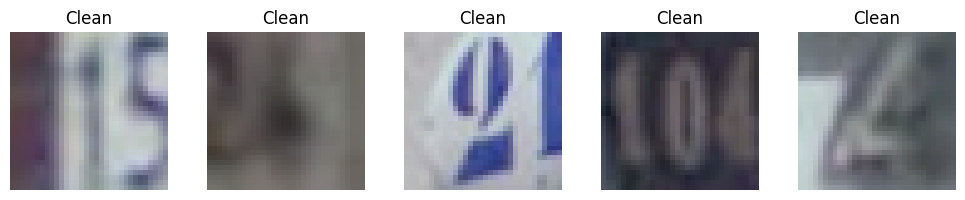

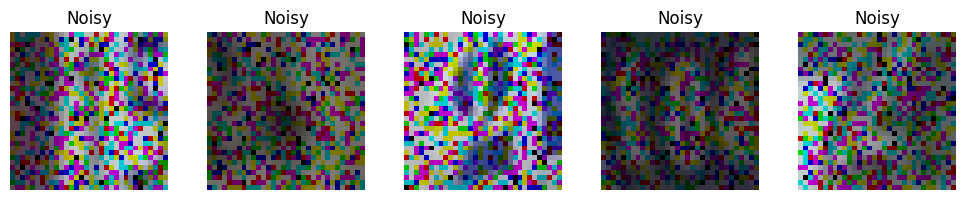

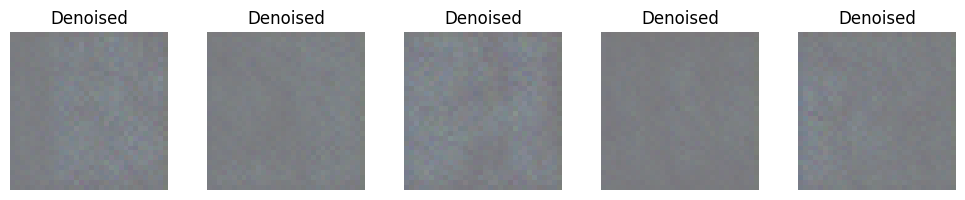

Epoch 06/100 - Train Loss: 0.039170, Test Loss: 0.111780
Epoch 07/100 - Train Loss: 0.038467, Test Loss: 0.111690
Epoch 08/100 - Train Loss: 0.037970, Test Loss: 0.111314
Epoch 09/100 - Train Loss: 0.037021, Test Loss: 0.111444
Epoch 10/100 - Train Loss: 0.036441, Test Loss: 0.111444


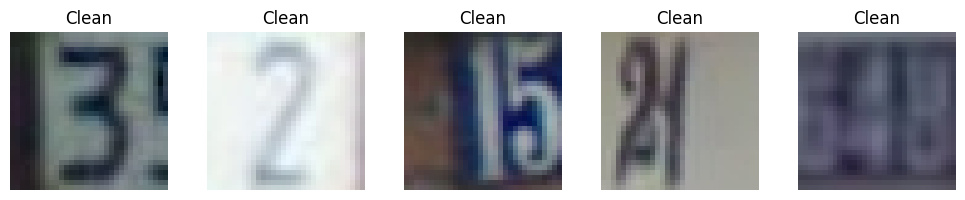

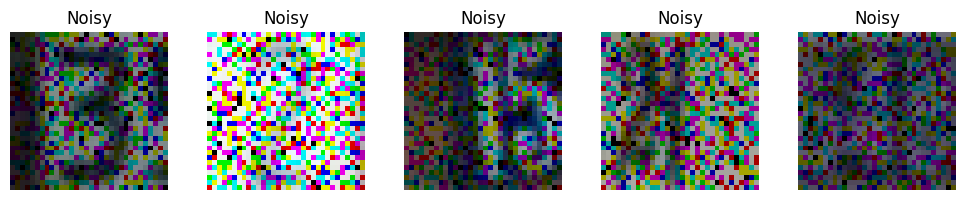

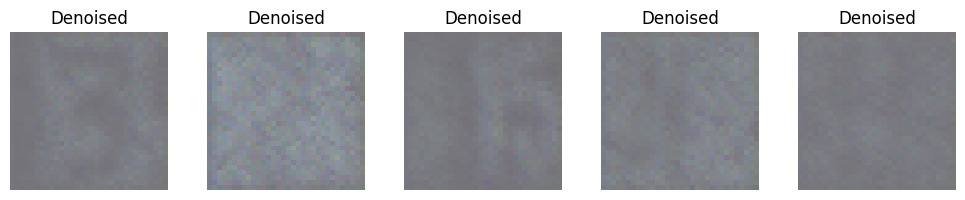

Epoch 11/100 - Train Loss: 0.035582, Test Loss: 0.111937
Epoch 12/100 - Train Loss: 0.034610, Test Loss: 0.111791
Epoch 13/100 - Train Loss: 0.033887, Test Loss: 0.112103
Epoch 14/100 - Train Loss: 0.032901, Test Loss: 0.112904
Epoch 15/100 - Train Loss: 0.032014, Test Loss: 0.113078


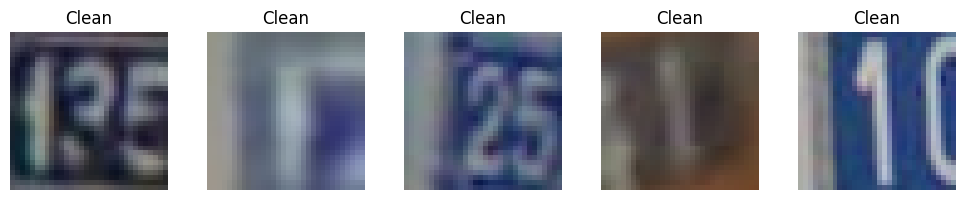

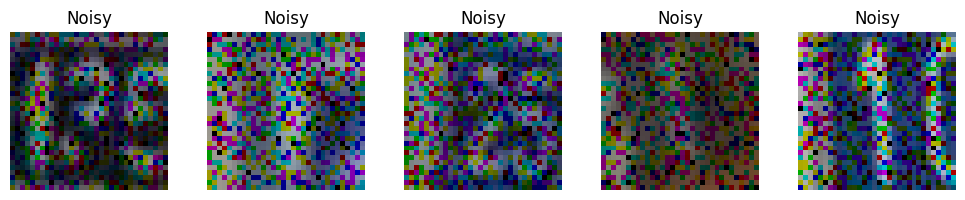

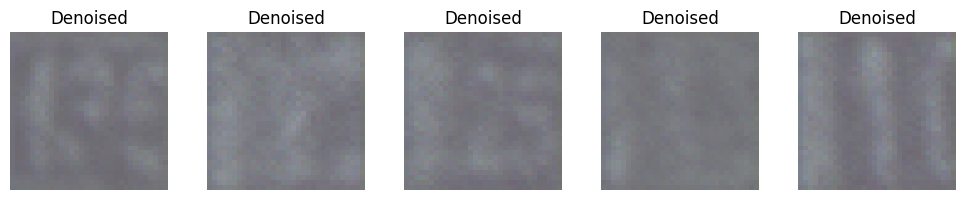

Epoch 16/100 - Train Loss: 0.031006, Test Loss: 0.113711
Epoch 17/100 - Train Loss: 0.029898, Test Loss: 0.114354
Epoch 18/100 - Train Loss: 0.028900, Test Loss: 0.114579
Epoch 19/100 - Train Loss: 0.027568, Test Loss: 0.114979
Epoch 20/100 - Train Loss: 0.026520, Test Loss: 0.115619


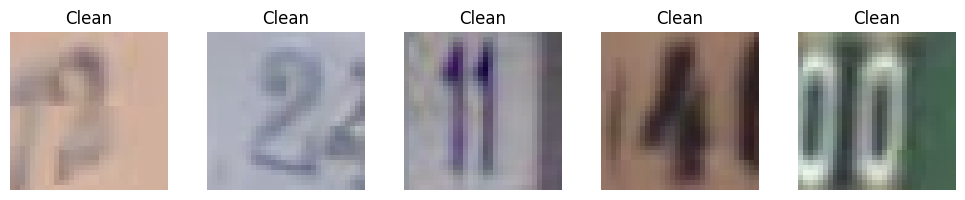

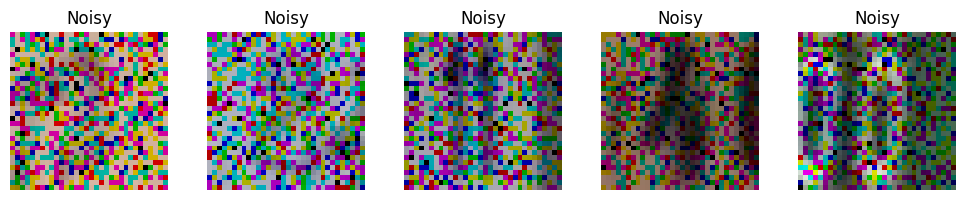

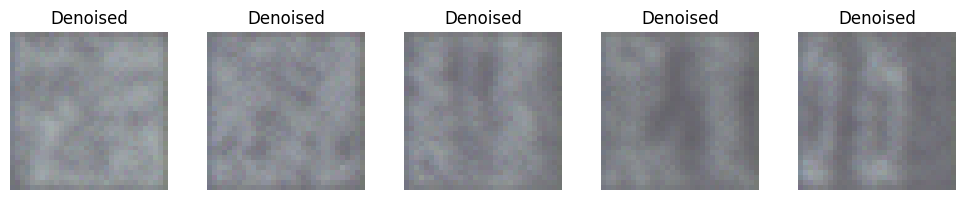

Epoch 21/100 - Train Loss: 0.025365, Test Loss: 0.116640
Epoch 22/100 - Train Loss: 0.024316, Test Loss: 0.117778
Epoch 23/100 - Train Loss: 0.023127, Test Loss: 0.118071
Epoch 24/100 - Train Loss: 0.021977, Test Loss: 0.119662
Epoch 25/100 - Train Loss: 0.020703, Test Loss: 0.120003


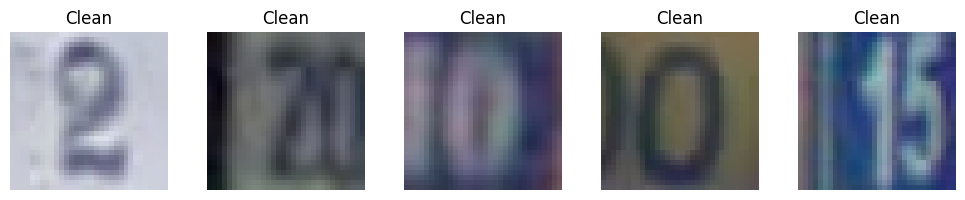

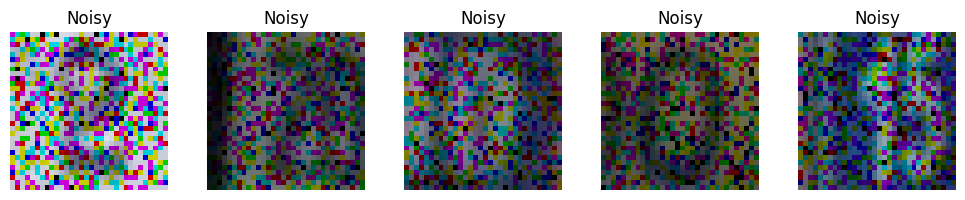

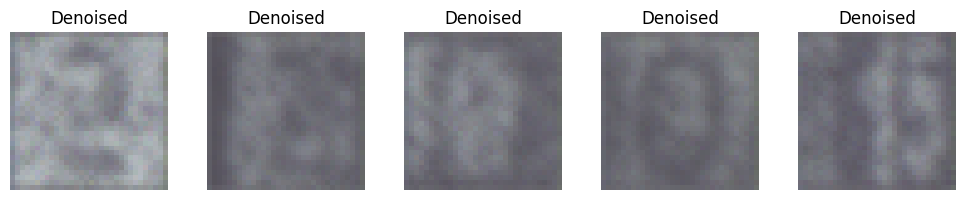

Epoch 26/100 - Train Loss: 0.019599, Test Loss: 0.120661
Epoch 27/100 - Train Loss: 0.018602, Test Loss: 0.122521
Epoch 28/100 - Train Loss: 0.017611, Test Loss: 0.123462
Epoch 29/100 - Train Loss: 0.016654, Test Loss: 0.124642
Epoch 30/100 - Train Loss: 0.015843, Test Loss: 0.126324


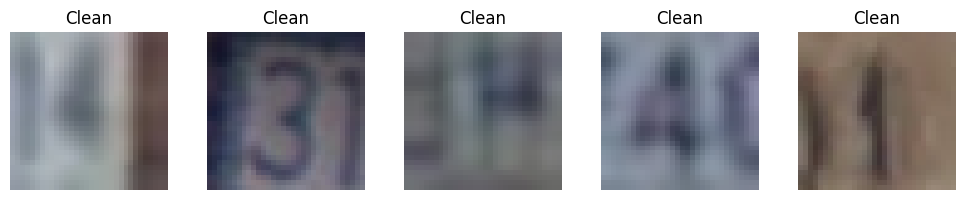

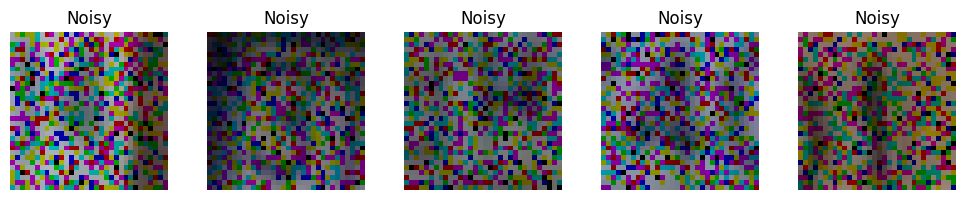

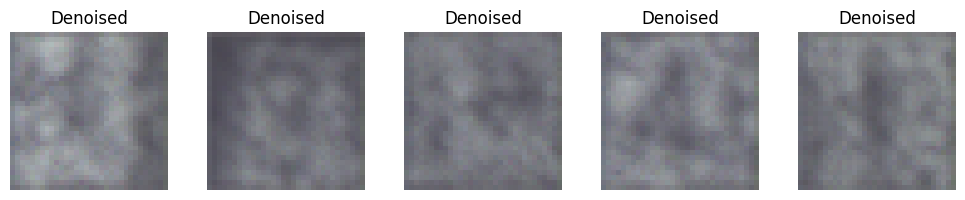

Epoch 31/100 - Train Loss: 0.014831, Test Loss: 0.126930
Epoch 32/100 - Train Loss: 0.014037, Test Loss: 0.129027
Epoch 33/100 - Train Loss: 0.013312, Test Loss: 0.129726
Epoch 34/100 - Train Loss: 0.012546, Test Loss: 0.130886
Epoch 35/100 - Train Loss: 0.012004, Test Loss: 0.132982


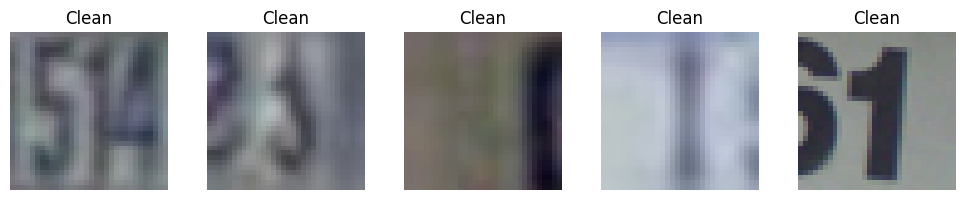

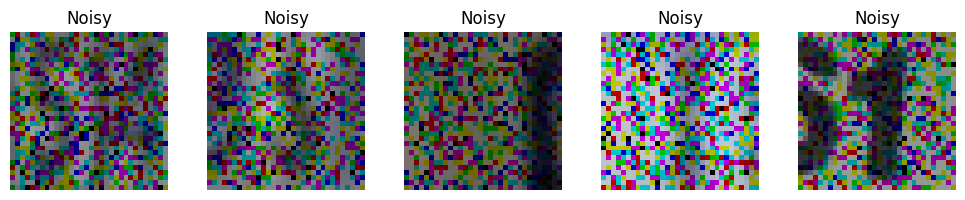

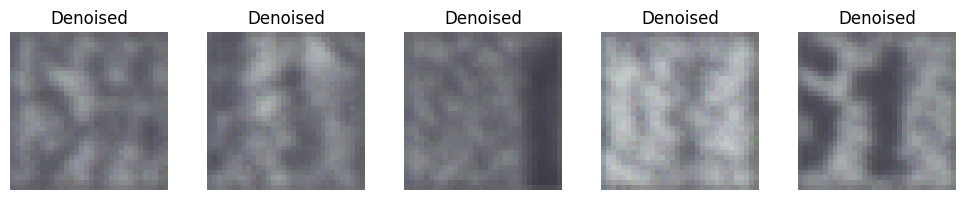

Epoch 36/100 - Train Loss: 0.011414, Test Loss: 0.133862
Epoch 37/100 - Train Loss: 0.010868, Test Loss: 0.134956
Epoch 38/100 - Train Loss: 0.010478, Test Loss: 0.136664
Epoch 39/100 - Train Loss: 0.010026, Test Loss: 0.137464
Epoch 40/100 - Train Loss: 0.009631, Test Loss: 0.137850


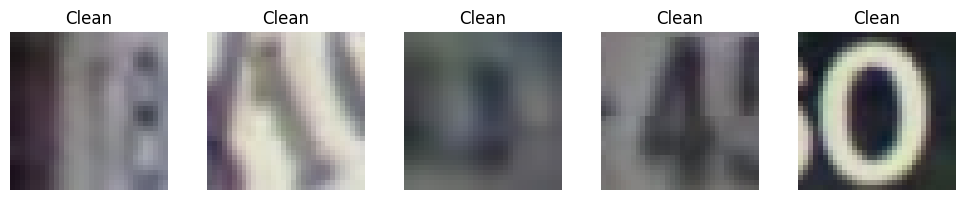

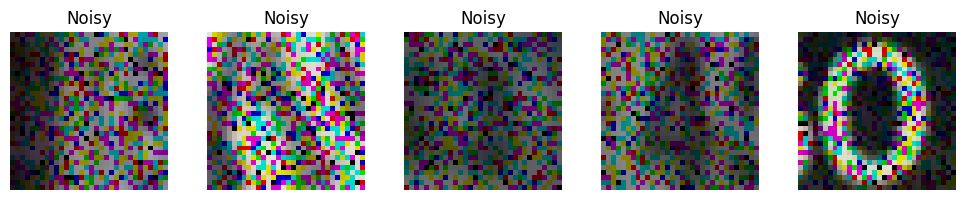

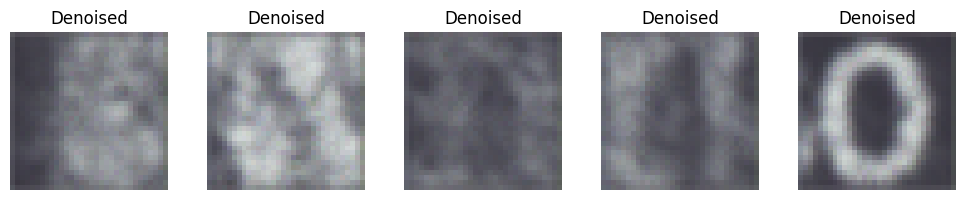

Epoch 41/100 - Train Loss: 0.009286, Test Loss: 0.139157
Epoch 42/100 - Train Loss: 0.009055, Test Loss: 0.140435
Epoch 43/100 - Train Loss: 0.008778, Test Loss: 0.141560
Epoch 44/100 - Train Loss: 0.008463, Test Loss: 0.142859
Epoch 45/100 - Train Loss: 0.008291, Test Loss: 0.143256


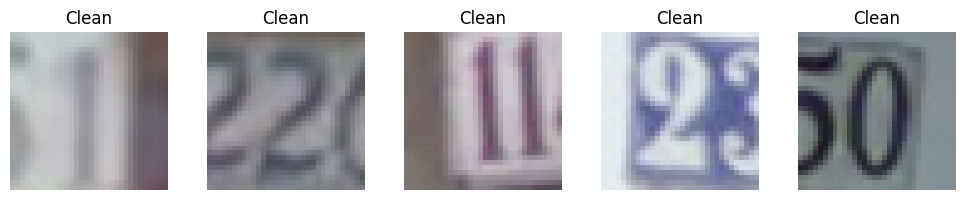

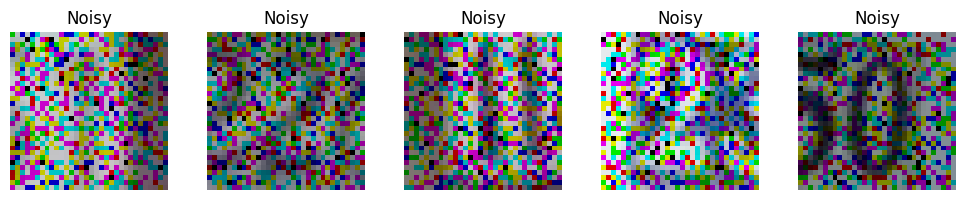

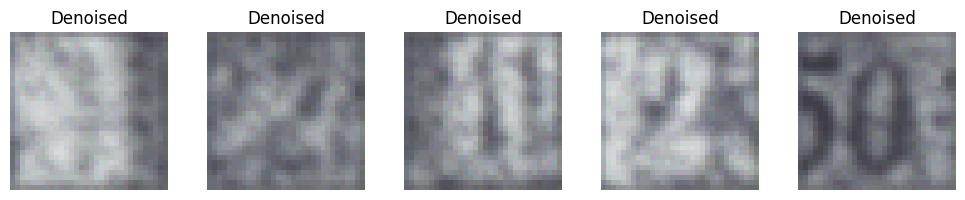

Epoch 46/100 - Train Loss: 0.008091, Test Loss: 0.143511
Epoch 47/100 - Train Loss: 0.007884, Test Loss: 0.144340
Epoch 48/100 - Train Loss: 0.007748, Test Loss: 0.145267
Epoch 49/100 - Train Loss: 0.007612, Test Loss: 0.146211
Epoch 50/100 - Train Loss: 0.007482, Test Loss: 0.146823


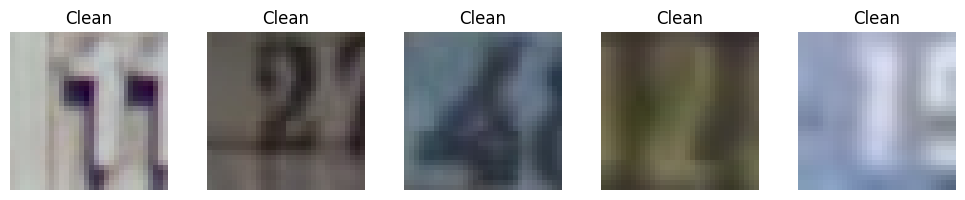

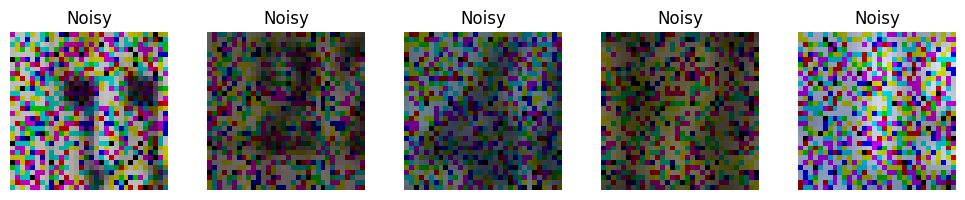

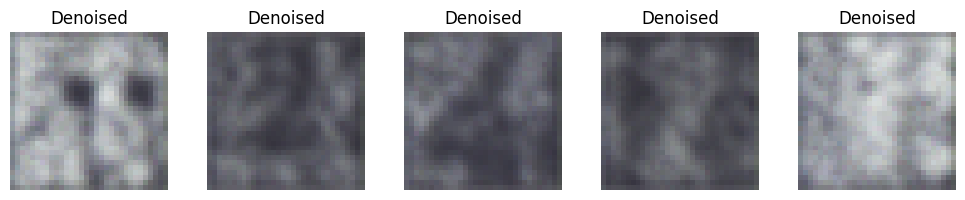

Epoch 51/100 - Train Loss: 0.007366, Test Loss: 0.146815
Epoch 52/100 - Train Loss: 0.007314, Test Loss: 0.147399
Epoch 53/100 - Train Loss: 0.007159, Test Loss: 0.147585
Epoch 54/100 - Train Loss: 0.007096, Test Loss: 0.147795
Epoch 55/100 - Train Loss: 0.007051, Test Loss: 0.148651


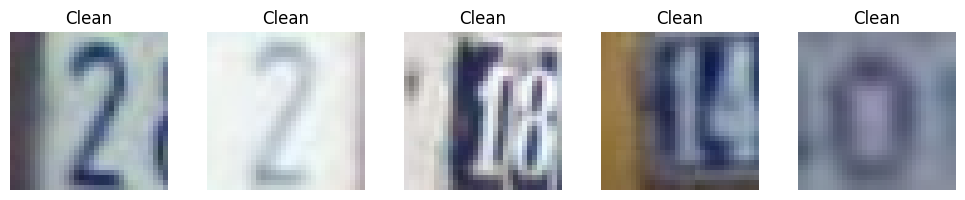

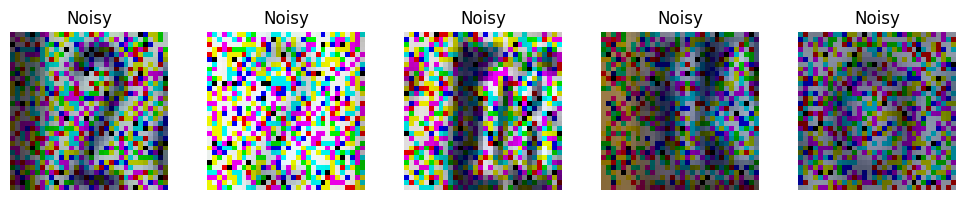

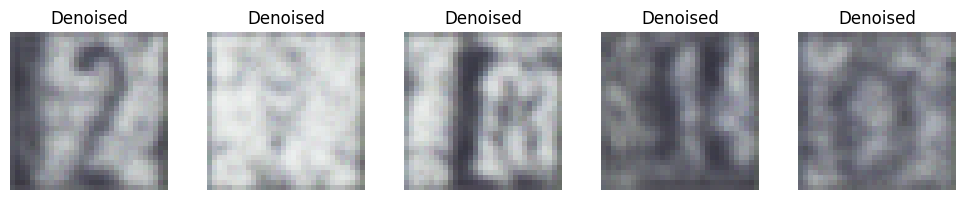

Epoch 56/100 - Train Loss: 0.006995, Test Loss: 0.149872
Epoch 57/100 - Train Loss: 0.006922, Test Loss: 0.149793
Epoch 58/100 - Train Loss: 0.006861, Test Loss: 0.149603
Epoch 59/100 - Train Loss: 0.006854, Test Loss: 0.150584
Epoch 60/100 - Train Loss: 0.006829, Test Loss: 0.150922


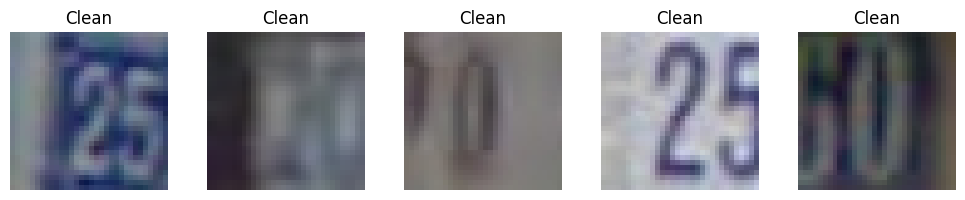

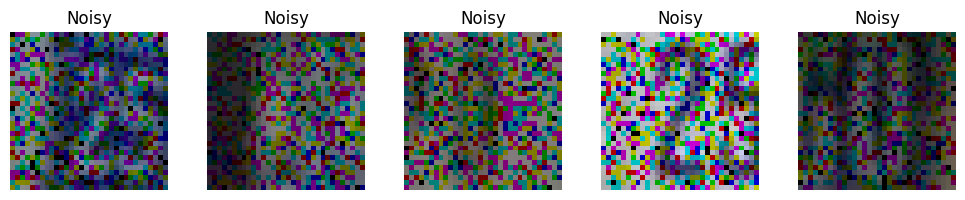

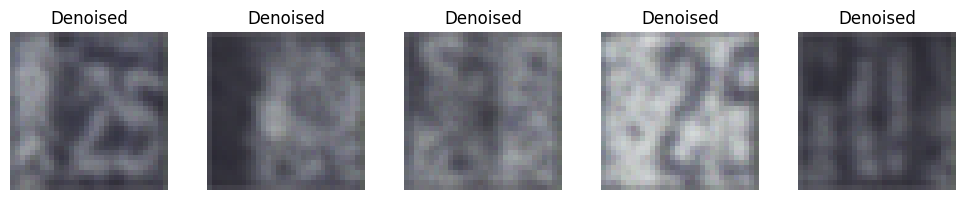

Epoch 61/100 - Train Loss: 0.006747, Test Loss: 0.150980
Epoch 62/100 - Train Loss: 0.006702, Test Loss: 0.151782
Epoch 63/100 - Train Loss: 0.006652, Test Loss: 0.151394
Epoch 64/100 - Train Loss: 0.006695, Test Loss: 0.152036
Epoch 65/100 - Train Loss: 0.006610, Test Loss: 0.151830


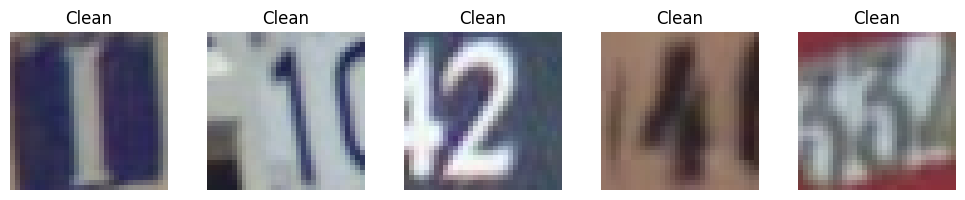

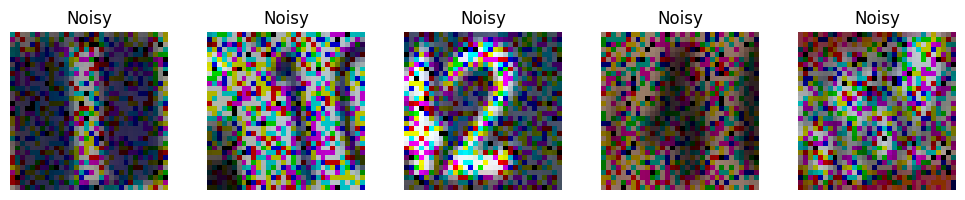

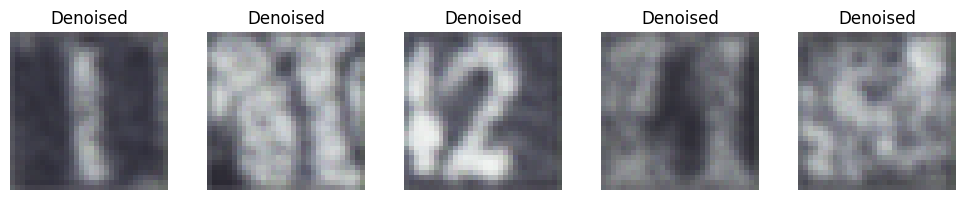

Epoch 66/100 - Train Loss: 0.006574, Test Loss: 0.152728
Epoch 67/100 - Train Loss: 0.006573, Test Loss: 0.152209
Epoch 68/100 - Train Loss: 0.006543, Test Loss: 0.152727
Epoch 69/100 - Train Loss: 0.006540, Test Loss: 0.152646
Epoch 70/100 - Train Loss: 0.006492, Test Loss: 0.153307


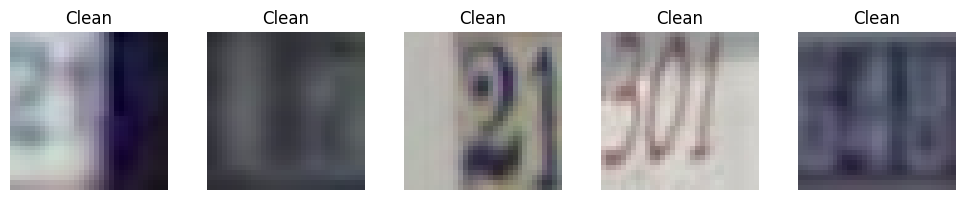

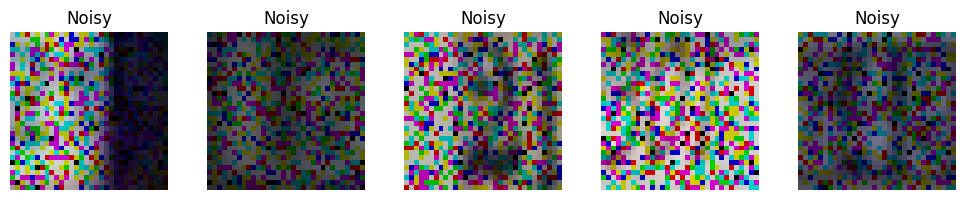

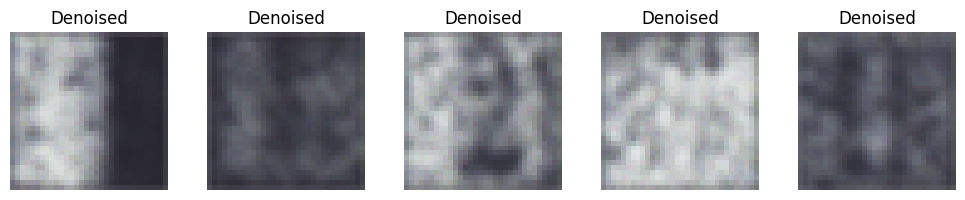

Epoch 71/100 - Train Loss: 0.006478, Test Loss: 0.153592
Epoch 72/100 - Train Loss: 0.006457, Test Loss: 0.153091
Epoch 73/100 - Train Loss: 0.006445, Test Loss: 0.154139
Epoch 74/100 - Train Loss: 0.006466, Test Loss: 0.153406
Epoch 75/100 - Train Loss: 0.006413, Test Loss: 0.153658


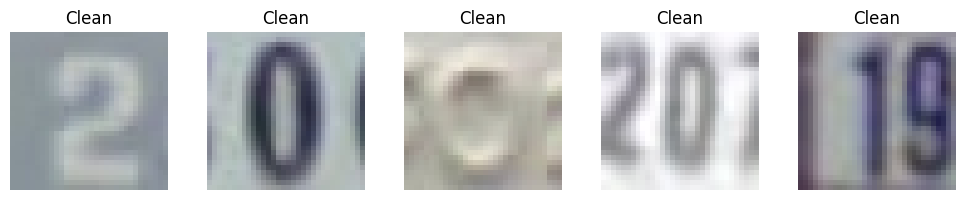

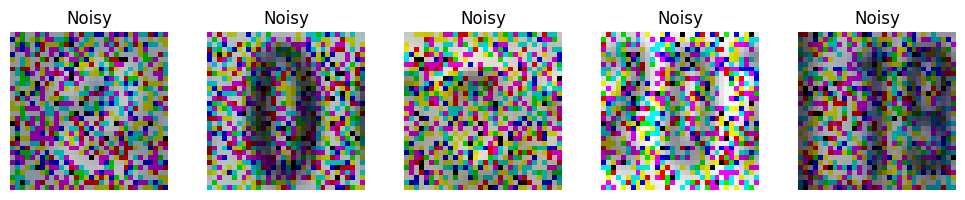

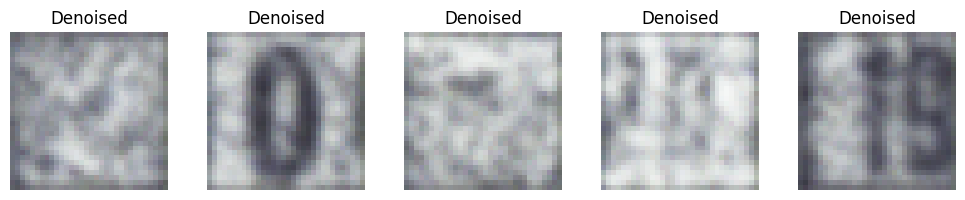

Epoch 76/100 - Train Loss: 0.006421, Test Loss: 0.153142
Epoch 77/100 - Train Loss: 0.006403, Test Loss: 0.153168
Epoch 78/100 - Train Loss: 0.006421, Test Loss: 0.153292
Epoch 79/100 - Train Loss: 0.006373, Test Loss: 0.153730
Epoch 80/100 - Train Loss: 0.006350, Test Loss: 0.153749


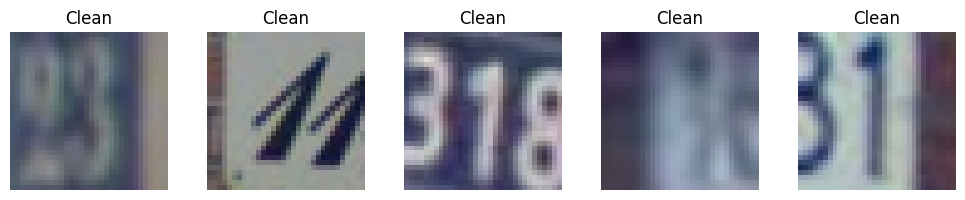

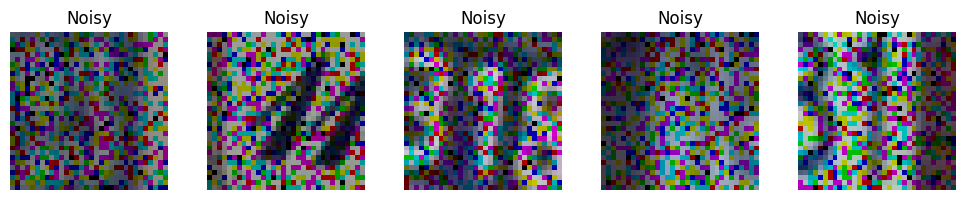

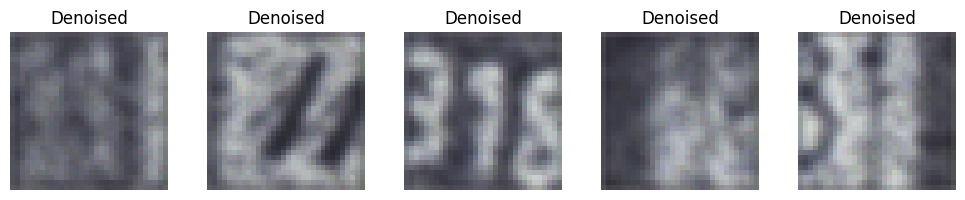

Epoch 81/100 - Train Loss: 0.006315, Test Loss: 0.153281
Epoch 82/100 - Train Loss: 0.006300, Test Loss: 0.153424
Epoch 83/100 - Train Loss: 0.006315, Test Loss: 0.153424
Epoch 84/100 - Train Loss: 0.006306, Test Loss: 0.154057
Epoch 85/100 - Train Loss: 0.006277, Test Loss: 0.153258


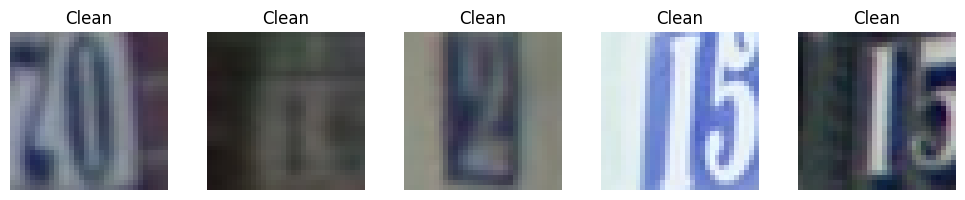

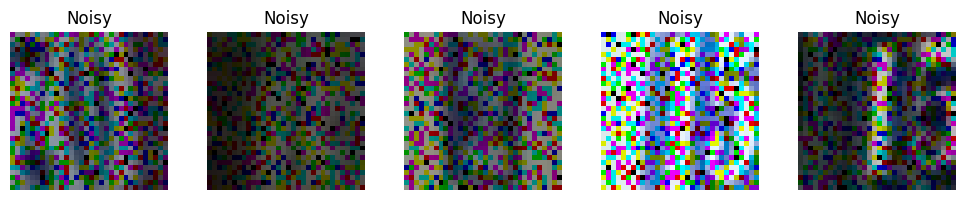

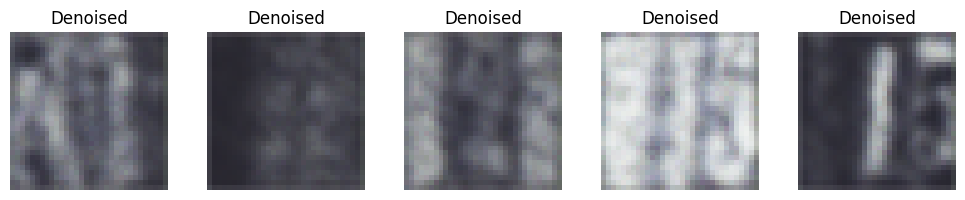

Epoch 86/100 - Train Loss: 0.006259, Test Loss: 0.153143
Epoch 87/100 - Train Loss: 0.006241, Test Loss: 0.153459
Epoch 88/100 - Train Loss: 0.006240, Test Loss: 0.153950
Epoch 89/100 - Train Loss: 0.006224, Test Loss: 0.153705
Epoch 90/100 - Train Loss: 0.006216, Test Loss: 0.153634


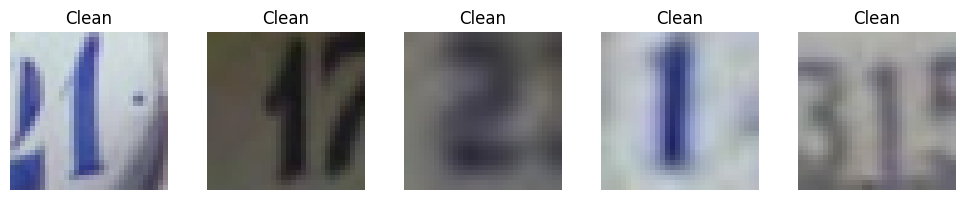

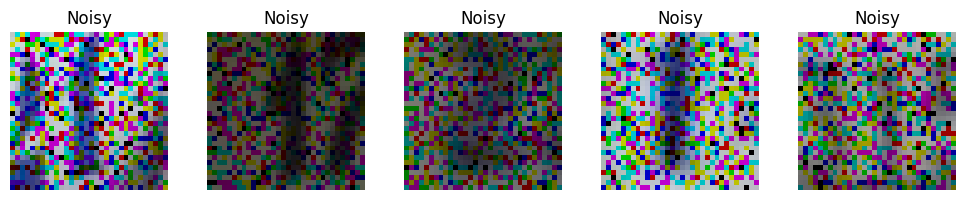

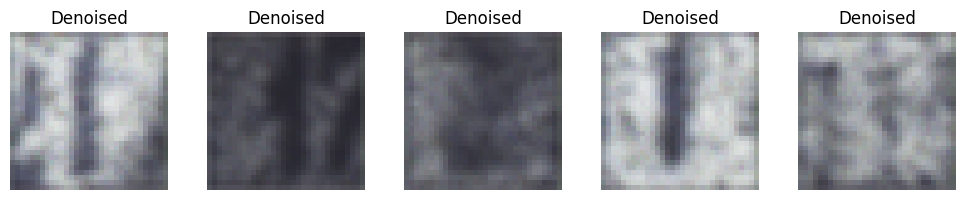

Epoch 91/100 - Train Loss: 0.006198, Test Loss: 0.152942
Epoch 92/100 - Train Loss: 0.006211, Test Loss: 0.153976
Epoch 93/100 - Train Loss: 0.006221, Test Loss: 0.153399
Epoch 94/100 - Train Loss: 0.006188, Test Loss: 0.153475
Epoch 95/100 - Train Loss: 0.006179, Test Loss: 0.153532


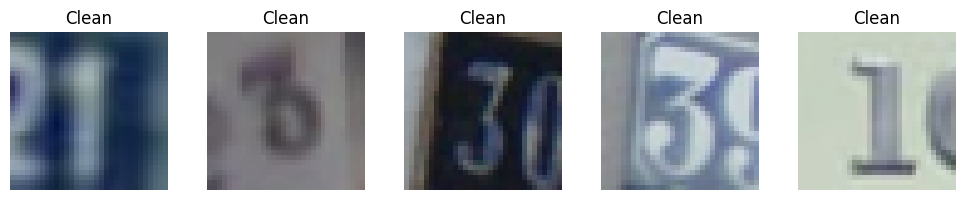

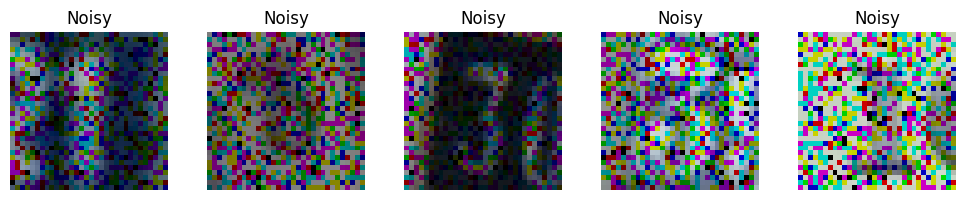

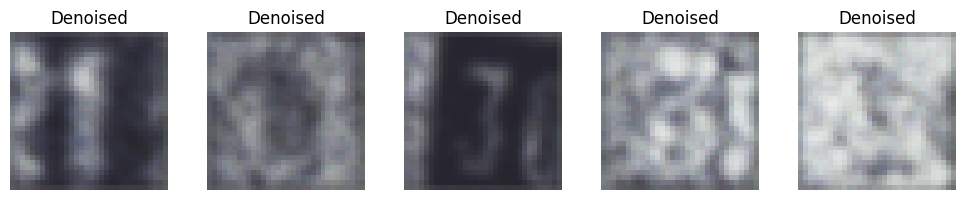

Epoch 96/100 - Train Loss: 0.006158, Test Loss: 0.152737
Epoch 97/100 - Train Loss: 0.006141, Test Loss: 0.153913
Epoch 98/100 - Train Loss: 0.006122, Test Loss: 0.153274
Epoch 99/100 - Train Loss: 0.006102, Test Loss: 0.152995
Epoch 100/100 - Train Loss: 0.006143, Test Loss: 0.153438


In [ ]:
# Denoise SVHN Images: Train the model to denoise images from the first 5 classes.
# Include the last epoch train/test values and last epoch sample images in your report.


learning_rate = 0.05
batch_size = 64
drop_rate = 0.3
num_samples = 1500
num_epochs = 100


model = ImageDenoisingCNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_epochs = []
test_loss_epochs = []


# Load data
classes = [0, 1, 2, 3, 4]
paired_trainloader_first_five = create_paired_dataloader(classes=classes, num_samples=num_samples,
                                                        batch_size=batch_size, drop_prob=drop_rate, split='train')

paired_testloader_first_five = create_paired_dataloader(classes=classes, num_samples=num_samples,
                                                       batch_size=batch_size, drop_prob=drop_rate, split='test')

# Train the model
train_loss_epochs, test_loss_epochs = train(paired_trainloader_first_five, paired_testloader_first_five,\
                                            model, num_epochs, criterion, optimizer, device)



## Plotting Training and Testing Losses Over Epochs**

To visualize the learning process of your model, plot the training and testing losses over each epoch. This allows us to evaluate model performance over time and helps identify potential issues, such as overfitting or underfitting.



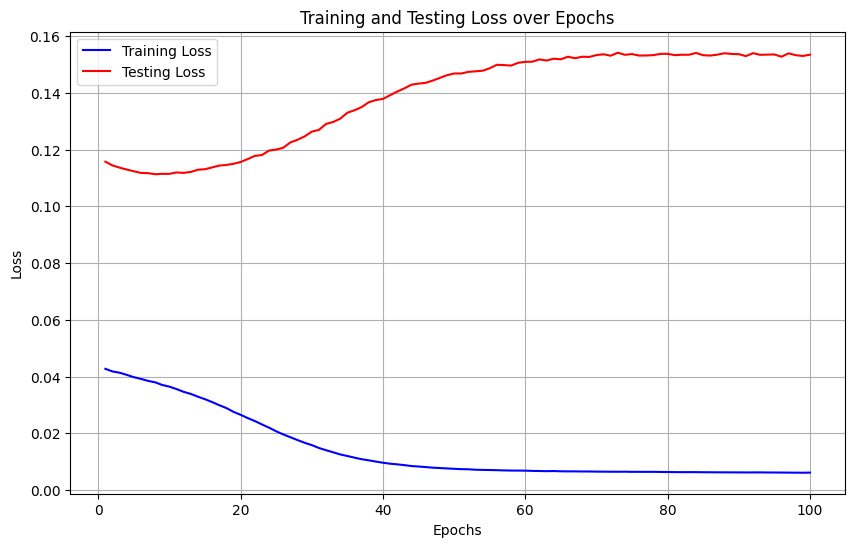

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_epochs, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), test_loss_epochs, label='Testing Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Denoising images from classes 5-9 of the SVHN dataset. Load test data for classes 5-9 with 1,500 samples per class

classes = [5, 6, 7, 8, 9]
paired_testloader_last_five = create_paired_dataloader(classes=classes, num_samples=num_samples,
                                                        batch_size=batch_size, drop_prob=drop_rate, split='test')


print(f'Number of batches in paired_testloader_last_five: {len(paired_testloader_last_five)}')



# Evaluate model on the last 5 classes test set and report loss

test_loss = evaluate(paired_testloader_last_five, model, criterion, device)
print(f'Test Loss for Last 5 Classes: {test_loss:.6f}')

Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Number of batches in paired_testloader_last_five: 24
Test Loss for Last 5 Classes: 0.155715


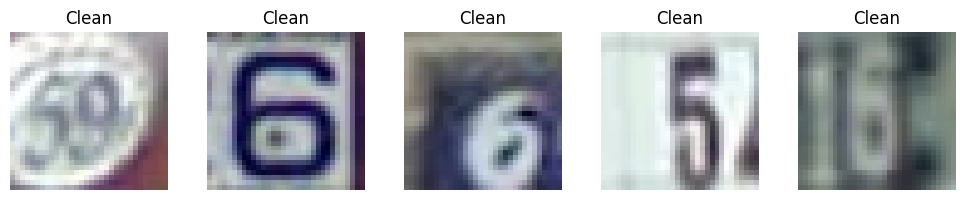

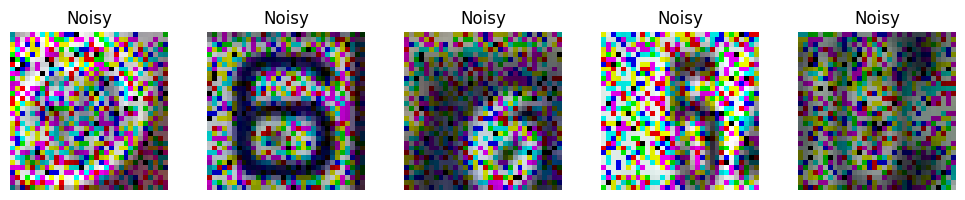

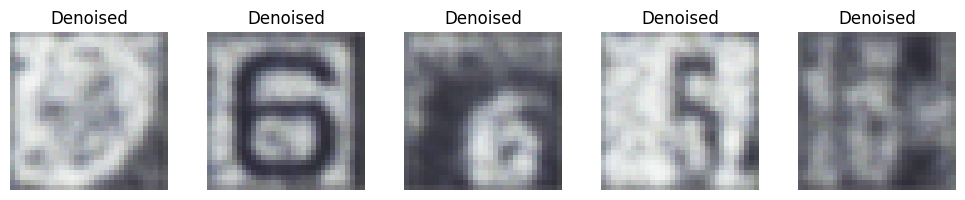

In [ ]:
# Visualize clean, noisy, and denoised images on last 5 classes

clean_images, noisy_images = next(iter(paired_testloader_last_five))
denoised_images = model(noisy_images.to(device))


# Display clean, noisy, and denoised images
show_images_grid2(clean_images[:5].detach(), title="Clean", cols=5)
show_images_grid2(noisy_images[:5].detach(), title="Noisy", cols=5)
show_images_grid2(denoised_images.detach().cpu(), title="Denoised", cols=5)